# Matched filter tutorial

This tutorial will show how to use the matched filter capabilities of PyKlip. 


## Preliminary

### Parallelized Performance (Use of mkl)
Refer to http://pyklip.readthedocs.io/en/latest/install.html#note-on-parallelized-performance for use of mkl.

In [1]:
try:
    import mkl
    mkl.set_num_threads(1)
except:
    print("Your code migth run slowly.")
    print("/!\ Please Read http://pyklip.readthedocs.io/en/latest/install.html#note-on-parallelized-performance")
    

### Klip POst Processing (KPOP)
The matched filter functionality are part of PyKlip's subpackage KPOP, referring to Klip POst Processing.

The KLIP POst Processing framework has been implemented with surveys application in mind. It includes several wrapper functions, which all ihnerit from the same object, and performing different tasks like matched filters, SNR map calculation, detection of high SNR blobs and others. A lot features have been automated and are therefore hidden from the user, which is appreciable when running the same sequence of tasks and many datasets.

### Speckle subtraction
The matched filter should be performed on speckle subtracted dataset so let's reduce a test dataset with PyKlip using http://pyklip.readthedocs.io/en/latest/klip_gpi.html.
This step can be skipped if reduced images are already available.

In [2]:
import os
import glob
import pyklip.instruments.GPI as GPI
import pyklip.parallelized as parallelized

pykliproot = os.path.dirname(os.path.realpath(parallelized.__file__))
inputDir = os.path.join(pykliproot,"..","tests","data")
outputDir = inputDir

Read dataset and run speckle subtraction:

In [ ]:
# Read the datacubes using the GPIData object
filelist = glob.glob(os.path.join(inputDir,"*spdc_distorcorr.fits"))
dataset = GPI.GPIData(filelist,highpass=True,meas_satspot_flux=False,numthreads=None)

parallelized.klip_dataset(dataset, outputdir=outputDir, fileprefix="bet_Pic_test",
                          annuli=9, subsections=4, movement=1, numbasis=[1,20,50,100],
                          calibrate_flux=True, mode="ADI+SDI")

## Cross Correlation

The cross correlation is the most basic type of matched filter. It assumes that the noise is identically distributed for all the pixels in the image. See discussion in Ruffio et al. (2017).

The following shows different cases for applying the cross correlation.

### Single cube. Independent slices.

For example, pyklip produces fits cube where each slice is the a collapsed spectral cube but using different number of KL modes (filename suffix is KLmodes-all). CrossCorr will process each slice independently.

~~ INITializing CrossCorr ~~
Reading File: /home/sda/jruffio/pyklip/tests/data/bet_Pic_test-KLmodes-all.fits
Generate gaussian PSF
Does the processed file exist? False
~~ Calculating CrossCorr with parameters crossCorrgaussian ~~
Saving: /home/sda/jruffio/pyklip/tests/data/kpop_pyklip//default_out//bet_Pic_test-KLmodes-all-crossCorrgaussian.fits
Output already exist: /home/sda/jruffio/pyklip/tests/data/kpop_pyklip//default_out//bet_Pic_test-KLmodes-all-crossCorrgaussian.fits
Does the processed file exist? True


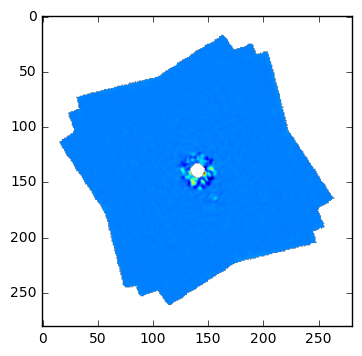

In [10]:
from pyklip.kpp.metrics.crossCorr import CrossCorr
# Definition of the cross correlation object
filename = "bet_Pic_test-KLmodes-all.fits"
read_func = lambda file_list:GPI.GPIData(file_list,recalc_centers=False,recalc_wvs=False,highpass=False)
cc_obj = CrossCorr(read_func,filename,kernel_type="gaussian",kernel_para=1.0,label="pyklip")

cc_obj.initialize(inputDir=inputDir,
                   outputDir=outputDir)
#check if the processed data exists
print("Does the processed file exist? {0}".format(cc_obj.check_existence()))
# Run cross correlation
cc_image = cc_obj.calculate()
# Save data to #pykliproot#/../tests/data/kpop_pyklip/default_out/bet_Pic_test-KLmodes-all-crossCorrgaussian.fits
cc_obj.save()
#check if the processed data exists
print("Does the processed file exist? {0}".format(cc_obj.check_existence()))

%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(cc_image[2,::-1,:])

### Single Spectral Cube

For example, pyklip produces spectral cube with the suffix "speccube". CrossCorr can first collapse the cube with a given spectrum before running the cross correlation.

Next cell generate the spectrum to be used as weights. Here we are using the atmospheric models from Marley et al. (2017, in prep.) and Saumon et al. 2012.

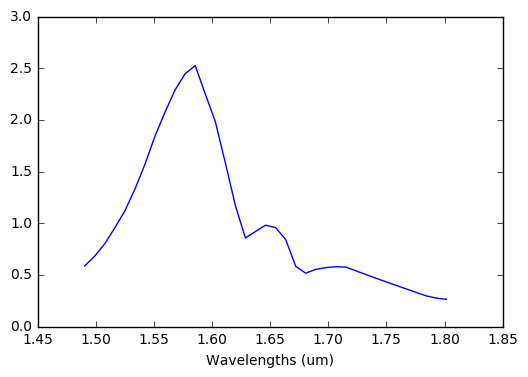

In [7]:
import pyklip.spectra_management as spec
import numpy as np
# T-type spectrum similar to 51 Eridani B in H-band.
reduc_spectrum = "t1000g100nc"
planet_spectrum_dir = glob.glob(os.path.join(pykliproot,"spectra","*",reduc_spectrum+".flx"))[0]
# Wavelengths channels in a H-band GPI cube
wvs =  GPI.get_gpi_wavelength_sampling("H")

# Interpolate spectrum
spectrum = spec.get_planet_spectrum(planet_spectrum_dir,wvs)[1]

## For GPI, it is possible to simply indicate the spectral band.
#spectrum = spec.get_planet_spectrum(planet_spectrum_dir,"H")[1]

import matplotlib.pyplot as plt
plt.plot(wvs,spectrum)
plt.xlabel("Wavelengths (um)")

Then we can run the cross correlation in the same way as before by simply using the two keywords "collapse=True,weights=spectrum".

In addition with specify the input folderName to be the spectrum name in case one wants to try out different templates. 

~~ INITializing CrossCorr ~~
Reading File: /home/sda/jruffio/pyklip/tests/data/bet_Pic_test-KL20-speccube.fits
Generate gaussian PSF
~~ Calculating CrossCorr with parameters crossCorrgaussian ~~
Saving: /home/sda/jruffio/pyklip/tests/data/kpop_pyklip/t1000g100nc//bet_Pic_test-KL20-speccube-crossCorrgaussian.fits


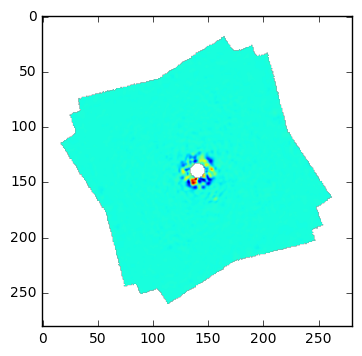

In [8]:

from pyklip.kpp.metrics.crossCorr import CrossCorr
# Definition of the cross correlation object
filename = "bet_Pic_test-KL20-speccube.fits"
read_func = lambda file_list:GPI.GPIData(file_list,recalc_centers=False,recalc_wvs=False,highpass=False)
cc_obj = CrossCorr(read_func,filename,kernel_type="gaussian",kernel_para=1.0,label="pyklip",
                   collapse=True,weights=spectrum,folderName=reduc_spectrum)

cc_obj.initialize(inputDir=inputDir,
                   outputDir=outputDir)
cc_image = cc_obj.calculate()
cc_obj.save()

import matplotlib.pyplot as plt
plt.imshow(cc_image[::-1,:])

### Multiple files with different reduction spectra

KPOP has been optimized to ease the reduction of survey data. Reducing one or several files requires the same number of lines of code. The function automating the process is called kppPerDir and take a list of objects (ie tasks to be executed) and a list of spectrum over which one iterate.

kppPerDir will automatically iterate over all the files matching the filename description (using wildcards).

In [ ]:
flat_reduc_spectrum = np.ones(37)

filename = "bet_Pic_test-KL*-speccube.fits"
cc_obj = CrossCorr(filename,kernel_type="gaussian",kernel_para=1.0,label="pyklip",
                   collapse=True,weights=spectrum,folderName=reduc_spectrum)
filename = os.path.join("kpop_pyklip","t1000g100nc","bet_Pic_test-KL*-speccube-crossCorrgaussian.fits")
snr_obj = StatPerPix(filename,type="SNR")

from pyklip.kpp.kppPerDir import kppPerDir
err_list = kppPerDir(inputDir,[cc_obj,snr_obj])

print("Printing error report:")
for err_str in err_list:
    print(err_str)

Then we can run a cross correlation on spectral cubes after performing a weighted mean collapse of the cube.

First, we need to define a spectrum that will be used for the weights. Here we are using the atmospheric models from Marley et al. (2017, in prep.) and Saumon et al. 2012.

Note that by not specifying the outputDir in the SNR calculation, the label and the folderName is inferred from the cross correlation map path.

In [ ]:

from pyklip.kpp.stat.statPerPix import StatPerPix
filename = os.path.join("kpop_pyklip","default_out","bet_Pic_test-KLmodes-all-crossCorrgaussian.fits")
snr_obj = StatPerPix(filename,type="SNR")

snr_obj.initialize(inputDir=inputDir)
snr_obj.calculate()
snr_obj.save()

Then we simply needs to indicate "collapse=True,weights=spectrum" and the CrossCorr object will collapse the cube automatically.

In [ ]:
from pyklip.kpp.metrics.crossCorr import CrossCorr
# Definition of the cross correlation object
filename = "bet_Pic_test-KL20-speccube.fits"
cc_obj = CrossCorr(filename,kernel_type="gaussian",label="pyklip",kernel_width=1.0,
                   collapse=True,weights=spectrum,folderName=reduc_spectrum)

cc_obj.initialize(inputDir=inputDir,
                   outputDir=outputDir)
cc_obj.calculate()
cc_obj.save()

from pyklip.kpp.stat.statPerPix import StatPerPix
filename = os.path.join("kpop_pyklip","t1000g100nc","bet_Pic_test-KL20-speccube-crossCorrgaussian.fits")
snr_obj = StatPerPix(filename,type="SNR")

snr_obj.initialize(inputDir=inputDir)
snr_obj.calculate()
snr_obj.save()

However, the KPOP framework facilitates the reduction of survey data.
Its principle is to define an object of every needed task. Objects are then executed with the kppPerDir function on all files satisfying the filename using wild characters. Also it automatically checks if the reduced file already exist to avoid wasting time (cf overwrite keyword).

In [ ]:

filename = "bet_Pic_test-KL*-speccube.fits"
cc_obj = CrossCorr(filename,kernel_type="gaussian",label="pyklip",kernel_width=1.0,
                   collapse=True,weights=spectrum,folderName=reduc_spectrum)
filename = os.path.join("kpop_pyklip","t1000g100nc","bet_Pic_test-KL*-speccube-crossCorrgaussian.fits")
snr_obj = StatPerPix(filename,type="SNR")

from pyklip.kpp.kppPerDir import kppPerDir
err_list = kppPerDir(inputDir,[cc_obj,snr_obj])

print("Printing error report:")
for err_str in err_list:
    print(err_str)

In [ ]:

# filename = "bet_Pic_test-KL*-speccube.fits"
# snr_obj = StatPerPix(filename,
#                          N_threads=None,label="FMMF",IOWA = None,
#                          type="SNR",overwrite=overwrite,GOI_list_folder=GOI_list_folder,mute=mute,resolution=resolution)

### Run FMMF
FMMF is meant to be ran on 16 (or above) cores machine with 60GB (or above) of RAM. Even with such computers, the code will take many hours to days to run on a normal dataset. Therefore, an iPython notebook is not an optimal mean to run this code. One should consider running a script with the linux command *nice* to let it run in the background. The ideal environment for this FMMF implementation is a supercluster where several dataset can be ran in parallel.

In [ ]:
inputDir = "../tests/data/"
outputDir = inputDir

FMMFObj.initialize(inputDir=inputDir,
                   outputDir=outputDir,
                   spectrum = "t1800g100nc",
                   compact_date="myDataDate")
FMMFObj.calculate()
FMMFObj.save()

## Advanced Features

**This section is in progress.**

Most of them are automatically treated by the FMMF object but one could want to take a closer look:
Sectors Definition, spectrum, Overlap, PSF cube, spectral type of the target, fakes management, noFM

Also all kppPerDir related features when reducing campaign data.